In [179]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1.Import Library

In [0]:
# import data
import os
from pathlib import Path
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from skimage import io

# train test split
from sklearn.model_selection import train_test_split

# modelling(CNN)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import callbacks

# modelling(transfer learning)
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras.models import Model

# metrics
import time
from IPython.display import clear_output
from keras import callbacks
from sklearn.metrics import classification_report
import pandas as pd

# save model
from keras.models import model_from_json
plt.rcParams['figure.figsize']=(20,5)

# 2.Custom Function

In [0]:
label_dict={0: "Tony Stark" ,1: "Eric Kwok" ,2: "Thor" ,3: "Kam Kong" ,4: "Brad Pitt" ,5:"Eason Chan" ,6:"Tzu chi" ,7:"Oscar Yiu", 8:"Others"}
def answer(Y_true,Y_head,model):
    head=label_dict[Y_head]
    true=label_dict[Y_true]
    if true==head:
        color=(0,0,255)
    else:
        color=(255,0,0)
    if model==1:
      size=(300,300,3)
    elif model==2:
      size=(224,224,3)
    img=np.ones(size)*color
    ans=(cv2.putText(img,head,(40,150),cv2.FONT_HERSHEY_SIMPLEX,1.3,(255,255,255),3,cv2.LINE_AA))
    return ans

In [0]:
def show_result(test_x,train_x,train_Y,test_Y,result):
  df=pd.DataFrame(result.history)
  df.columns=['val_loss', 'Testing Accuracy', 'loss', 'Training Accuracy']
  ax1=plt.subplot(111)
  df[['Testing Accuracy','Training Accuracy']].plot(ax=ax1)
  plt.title('Testing Accuracy and Training Accuracy in each Epoch (Custom CNN)',fontsize='xx-large')
  plt.legend(fontsize='xx-large')
  plt.show()


  test_y_head=model.predict(test_x)
  train_y_head=model.predict(train_x)
  test_Y_head=[np.argmax(y) for y in test_y_head]
  train_Y_head=[np.argmax(y) for y in train_y_head]
  target_names=label_dict.values()
  print(f'Training: \n{classification_report(train_Y,train_Y_head,target_names=target_names)}\nTesting: \n{classification_report(test_Y,test_Y_head,target_names=target_names)}')

In [0]:
def argmax(y,threshold):
  if (y<threshold).sum()==len(y[0]):
    return 8
  else:
    return np.argmax(y)
    

# 3.Import Data

In [266]:
Y=[]
X=[]
for i in range(8):
    Y_each=[i for url in Path(f'./gdrive/My Drive/Colab Notebooks/Fun classifier/face/{i}').glob('*.png')]
    Y+=Y_each
      #  Custom CNN
#     X+=[image.img_to_array(image.load_img(str(url),target_size=(300,300)),dtype='float32')/255
#         for url in Path(f'./gdrive/My Drive/Colab Notebooks/Fun classifier/face/{i}').glob('*.png')]
     # Transfer Learing
    X+=[image.img_to_array(image.load_img(str(url),target_size=(224,224)),dtype='float32')
        for url in Path(f'./gdrive/My Drive/Colab Notebooks/Fun classifier/face/{i}').glob('*.png')]
    print(f"Imgae in Label {i}: {len(Y_each)}")

Imgae in Label 0: 125
Imgae in Label 1: 167
Imgae in Label 2: 140
Imgae in Label 3: 139
Imgae in Label 4: 103
Imgae in Label 5: 155
Imgae in Label 6: 109
Imgae in Label 7: 120


# 4.Train Test Split

In [0]:
train_X,test_X,train_Y,test_Y=train_test_split(X,Y,test_size=0.2,random_state=30)

# 5.Preprocessing

# 5a.Custom CNN

In [0]:
test_x=np.array(test_X)
train_x=np.array(train_X)
test_y=keras.utils.to_categorical(test_Y)
train_y=keras.utils.to_categorical(train_Y)

# 5b.Transfer Learning

In [0]:
test_x=preprocess_input(test_X)
train_x=preprocess_input(train_X)

# 6.Modeling

# 6a.Custom CNN

In [0]:
model=Sequential()
model.add(Conv2D(50,kernel_size=(10,10),activation='relu'))
model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Conv2D(50,kernel_size=(10,10),activation='relu'))
model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Flatten())
model.add(Dense(units=200 ,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=100,activation='relu'))
model.add(Dense(8,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# 6b.Transfer Learning

In [0]:
base_model=VGGFace()
for layer in base_model.layers:
  layer.trainable=False
  

In [189]:
# classifier
x=base_model.output
x=Dense(units=200,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(units=100,activation='relu')(x)
prediction=Dense(units=8,activation='softmax')(x)

# combine model
model = Model(inputs=base_model.input, outputs=prediction)

print(model.summary())
# compile
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [190]:
result=model.fit(train_x,train_y,epochs=80,batch_size=100,
          validation_data=(test_x,test_y),
        callbacks=[callbacks.EarlyStopping(patience=10,monitor='val_acc')])


Train on 846 samples, validate on 212 samples
Epoch 1/80
846/846 [==============================] - 12s 14ms/step - loss: 2.0663 - acc: 0.3262 - val_loss: 2.0426 - val_acc: 0.4575
Epoch 2/80
846/846 [==============================] - 11s 13ms/step - loss: 2.0259 - acc: 0.4243 - val_loss: 1.9824 - val_acc: 0.4670
Epoch 3/80
846/846 [==============================] - 11s 13ms/step - loss: 1.9542 - acc: 0.4728 - val_loss: 1.8866 - val_acc: 0.5189
Epoch 4/80
846/846 [==============================] - 11s 13ms/step - loss: 1.8491 - acc: 0.5485 - val_loss: 1.7417 - val_acc: 0.6179
Epoch 5/80
846/846 [==============================] - 11s 13ms/step - loss: 1.6936 - acc: 0.6111 - val_loss: 1.5524 - val_acc: 0.6698
Epoch 6/80
846/846 [==============================] - 11s 13ms/step - loss: 1.5065 - acc: 0.6809 - val_loss: 1.3451 - val_acc: 0.7075
Epoch 7/80
846/846 [==============================] - 11s 13ms/step - loss: 1.3114 - acc: 0.7080 - val_loss: 1.1436 - val_acc: 0.7311
Epoch 8/80
846/8

# 7.Show result

In [0]:
def show_result(test_x,train_x,train_Y,test_Y,result):
  df=pd.DataFrame(result.history)
  df.columns=['val_loss', 'Testing Accuracy', 'loss', 'Training Accuracy']
  ax1=plt.subplot(111)
  df[['Testing Accuracy','Training Accuracy']].plot(ax=ax1)
  plt.title('Testing Accuracy and Training Accuracy in each Epoch (Custom CNN)',fontsize='xx-large')
  plt.legend(fontsize='xx-large')
  plt.show()


  test_y_head=model.predict(test_x)
  train_y_head=model.predict(train_x)
  test_Y_head=[np.argmax(y) for y in test_y_head]
  train_Y_head=[np.argmax(y) for y in train_y_head]
  target_names=label_dict.values()
  print(f'Training: \n{classification_report(train_Y,train_Y_head,target_names=target_names)}\nTesting: \n{classification_report(test_Y,test_Y_head,target_names=target_names)}')

# 7a.Custom CNN

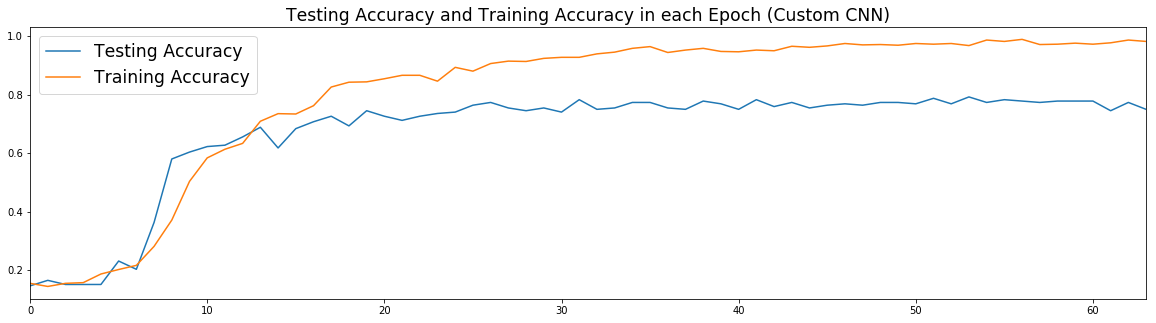

Training: 
              precision    recall  f1-score   support

  Tony Stark       1.00      1.00      1.00       102
   Eric Kwok       1.00      1.00      1.00       136
        Thor       1.00      1.00      1.00       106
    Kam Kong       1.00      1.00      1.00       115
   Brad Pitt       1.00      1.00      1.00        79
  Eason Chan       1.00      1.00      1.00       129
     Tzu chi       1.00      1.00      1.00        87
   Oscar Yiu       1.00      1.00      1.00        92

    accuracy                           1.00       846
   macro avg       1.00      1.00      1.00       846
weighted avg       1.00      1.00      1.00       846

Testing: 
              precision    recall  f1-score   support

  Tony Stark       0.71      0.65      0.68        23
   Eric Kwok       0.74      0.84      0.79        31
        Thor       0.76      0.82      0.79        34
    Kam Kong       0.70      0.79      0.75        24
   Brad Pitt       0.94      0.62      0.75        24
  E

In [0]:
show_result(test_x,train_x,train_Y,test_Y,result)

# 7b.Transfer Learning

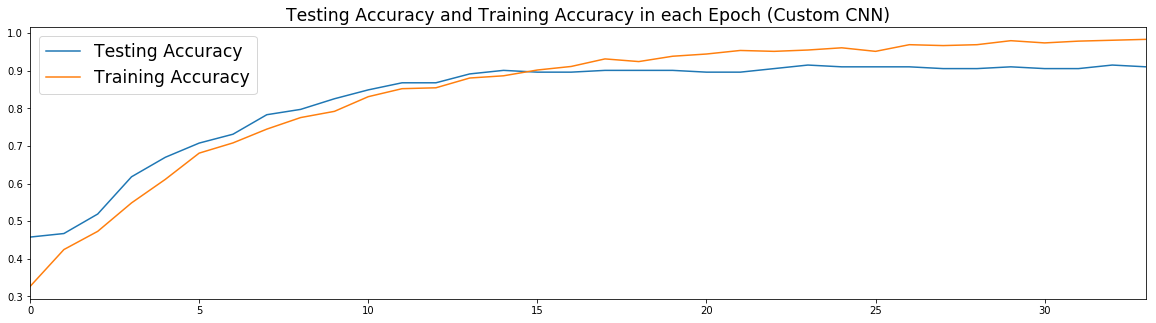

Training: 
              precision    recall  f1-score   support

  Tony Stark       1.00      1.00      1.00       102
   Eric Kwok       1.00      0.98      0.99       136
        Thor       1.00      1.00      1.00       106
    Kam Kong       0.99      1.00      1.00       115
   Brad Pitt       1.00      1.00      1.00        79
  Eason Chan       0.96      0.98      0.97       129
     Tzu chi       0.98      0.97      0.97        87
   Oscar Yiu       0.97      0.97      0.97        92

    accuracy                           0.99       846
   macro avg       0.99      0.99      0.99       846
weighted avg       0.99      0.99      0.99       846

Testing: 
              precision    recall  f1-score   support

  Tony Stark       0.95      0.91      0.93        23
   Eric Kwok       0.93      0.90      0.92        31
        Thor       0.97      1.00      0.99        34
    Kam Kong       0.91      0.88      0.89        24
   Brad Pitt       1.00      0.96      0.98        24
  E

In [192]:
show_result(test_x,train_x,train_Y,test_Y,result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


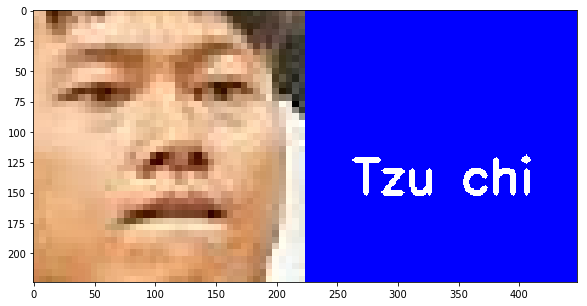

continue? 0


In [205]:
for i in range(len(test_Y)):
    clear_output(wait=True)
    ans=answer(test_Y[i],test_Y_head[i],2)
    plt.imshow(np.concatenate([test_X[i]/255,ans],axis=1))
    plt.show()
    time.sleep(1)
    if i>0 and i%10==0:
      x=input('continue? ')
      if x=="0":
        break

# 8.Save Model

In [0]:
model_structure=model.to_json()
f = Path("./gdrive/My Drive/Colab Notebooks/Fun classifier/model/Funny_classifier_TL_structure.json")
f.write_text(model_structure)
model.save_weights('./gdrive/My Drive/Colab Notebooks/Fun classifier/model/Funny_classifier_TL_weights.h5')

# 9.Import Model

In [0]:
f = Path("./gdrive/My Drive/Colab Notebooks/Fun classifier/model/Funny_classifier_cnn_structure.json")
model_structure=f.read_text()
model=model_from_json(model_structure)
model.load_weights("./gdrive/My Drive/Colab Notebooks/Fun classifier/model/Funny_classifier_cnn_weights.h5")

# 10. Classifier Single X

# 10a. Custom CNN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


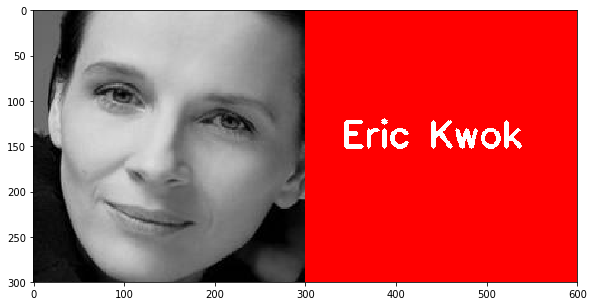

In [277]:
X=np.array(image.load_img('./gdrive/My Drive/Colab Notebooks/Fun classifier/sample5.png',target_size=(300,300)),dtype='float32')
y_head=model.predict(X.reshape(1,300,300,3)/255)
Y_head=argmax(y_head,0.5)
plt.imshow(np.concatenate([X/255,answer(8,Y_head,1)],axis=1))

# 10b. Transfer Learning

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


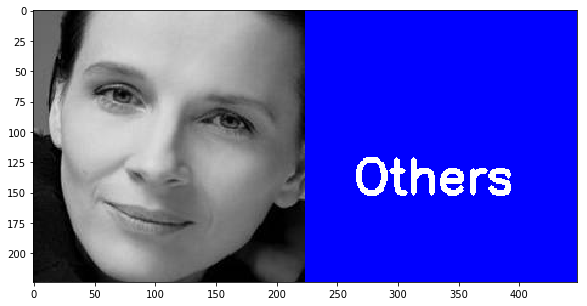

In [268]:
X=np.array(image.load_img('./gdrive/My Drive/Colab Notebooks/Fun classifier/sample5.png',target_size=(224,224)),dtype='float32')
x=preprocess_input(X)
y_head=model.predict(x.reshape((1,224,224,3)))
Y_head=argmax(y_head,0.5)
plt.imshow(np.concatenate([X/255,answer(8,Y_head,2)],axis=1))